In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import multivariate_normal
import scipy.io as scio
import pandas as pd

In [2]:
dataFile = 'data/1_data.mat'
data = scio.loadmat(dataFile) # data['t'] data['x']

In [3]:
# shuffle
arr = np.concatenate((data['x'], data['t']), axis=1)

data = [data['x'], data['t']]
df = pd.DataFrame(arr, columns=['x','t'])
df = df.sample(frac=1).reset_index(drop=True)

data = dict()
data['x'] = df['x'].values.reshape(100, 1)
data['t'] = df['t'].values.reshape(100, 1)

In [4]:
def my_inverse_matrix(matrix):
    dimension = matrix.shape[0]
    diagnoal = np.eye(dimension, dtype=float) 
    
    for d in range(dimension):
        temp = matrix[d][d]
        for c in range(dimension):
            matrix[d][c] = matrix[d][c]/temp
            diagnoal[d][c] = diagnoal[d][c]/temp
        for r in range(dimension):
            mu = -matrix[r][d]
            if r != d:
                for c in range(dimension):
                    matrix[r][c] = matrix[d][c] * mu + matrix[r][c]
                    diagnoal[r][c] = diagnoal[d][c]*mu + diagnoal[r][c]
    return diagnoal

def sigmoid(a):
    # σ(a) = 1 / (1 + exp(−a))
    return 1 / (1 + np.exp(-a))


$ y(x, w)=w_0+\sum_{j=1}^{M-1}w_j\phi_j(x) $   

In [5]:
class RegressionModel:
    def __init__(self, M=7, s=0.1): 
        self.M = M
        self.s = s
    
    def basis_function(self, x):
        # M: number of parameter
        # μj: govern the locations of the basis functions in input space
        # s: governs their spatial scale.
        M, s = self.M, self.s
        new_x = np.empty([len(x), 0])

        for j in range(0, M):
            mu = 4*j/M
            new_x = np.concatenate((new_x, sigmoid((x-mu)/s)), axis=1)
        return new_x
    
    def posterior_distrib(self, x, t, alpha=math.pow(10, -6), beta=1):
        M, s = self.M, self.s
        
        phi = self.basis_function(x)
        SN_inv = alpha*np.eye(M) + beta*phi.T.dot(phi)
        SN = my_inverse_matrix(SN_inv)
        mN = beta*SN.dot(phi.T).dot(t)
        return mN, SN
    
    def predict(self, x, w):
        return x.dot(w)
    
    def predict_distrib(self, x, mN, SN, beta=1):
        phi = self.basis_function(x)
#         mean = mN.dot(phi.T)
        mean = phi.dot(mN)
        cov = 1/beta + np.sum(phi.dot(SN).dot(phi.T), axis=1)
        SD = np.sqrt(cov)
        return mean.reshape(len(x)), SD


$$ m_N=\beta S_N\Phi^Tt $$
$$ S_N^{-1}=\alpha I+\beta\Phi^T\Phi $$

Prior $$ p(w|\alpha)=N(w|m_0=0, S_0^{-1}=\alpha^{-1}I) $$
$$ \alpha = 10^{-6} $$
Precision of likelihood function p(t|w, β) $$\beta=1$$

# 1. compute the mean vector $m_N$ and the covariance matrix $S_N$ for the posterior distribution

In [6]:
N_list = [10, 15, 30, 50, 80]
for N in N_list:
    RM = RegressionModel()
    x = data['x'][:N]
    t = data['t'][:N]
    
    mN, SN = RM.posterior_distrib(x, t)
    
    print("data size", N, "\n\tmean", mN, "\n\tconvariance", SN)
    print()

data size 10 
	mean [[ 4.03366371]
 [ 3.99877765]
 [-2.4051087 ]
 [ 1.5272439 ]
 [-3.44643231]
 [-3.1976605 ]
 [-2.55696152]] 
	convariance [[ 4.98188639e+05 -4.99894216e+05  1.68246017e+03  3.88622430e+01
  -1.73114766e+01  1.81873873e+00 -3.91433676e-01]
 [-4.99894216e+05  5.02001064e+05 -2.13474885e+03  4.47321909e+01
  -1.85037141e+01  1.94244194e+00 -4.17980817e-01]
 [ 1.68246017e+03 -2.13474885e+03  5.11096003e+02 -9.64235181e+01
   4.13552567e+01 -4.34313453e+00  9.34662265e-01]
 [ 3.88622430e+01  4.47321909e+01 -9.64235181e+01  2.21280262e+01
  -1.02304408e+01  1.08240578e+00 -2.33504671e-01]
 [-1.73114766e+01 -1.85037141e+01  4.13552567e+01 -1.02304408e+01
   5.94263428e+00 -1.50834682e+00  3.97707066e-01]
 [ 1.81873873e+00  1.94244194e+00 -4.34313453e+00  1.08240578e+00
  -1.50834682e+00  2.51162826e+00 -2.36932830e+00]
 [-3.91433676e-01 -4.17980817e-01  9.34662265e-01 -2.33504671e-01
   3.97707066e-01 -2.36932830e+00  4.05869907e+00]]

data size 15 
	mean [[-1.5958848 ]
 [ 0

# 2. Similar to Fig. 3.9, please generate five curve samples from the parameter posterior distribution.


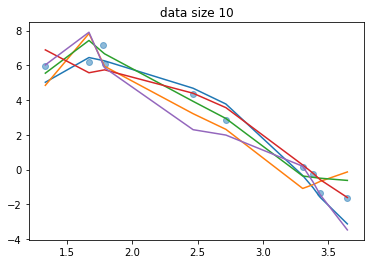

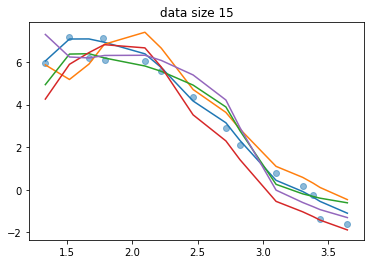

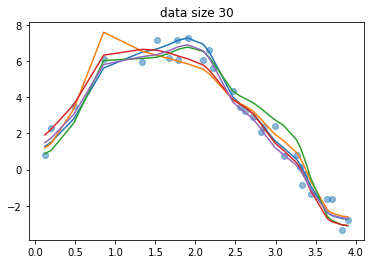

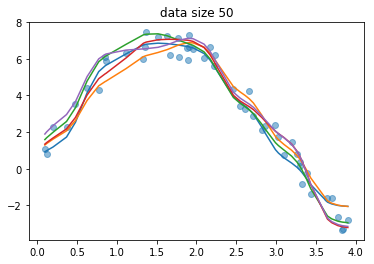

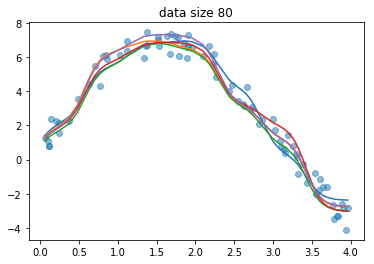

In [7]:
N_list = [10, 15, 30, 50, 80]
# N_list = [10]
for N in N_list:
    RM = RegressionModel()
    x = data['x'][:N]
    t = data['t'][:N]

    mN, SN = RM.posterior_distrib(x, t)
    w = multivariate_normal(mean=mN.reshape(RM.M), cov=SN).rvs(size=5)

    plt.scatter(x, t, alpha = 0.5)
    
    x = np.array(sorted(x))

    for _w in w:
        y = RM.predict(_w, RM.basis_function(x).T)
        plt.title('data size %d' % N)
        plt.plot(x, y, '-')
    plt.show()

# 3. Similar to Fig. 3.8, please plot the predictive distribution of target value t and show the mean curve and the region of variance with one standard deviation on either side of the mean curve.


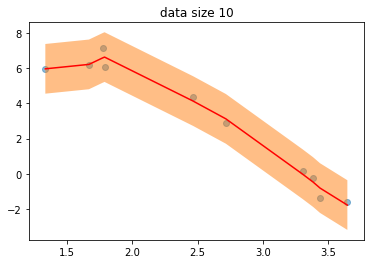

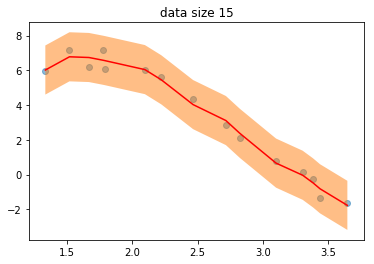

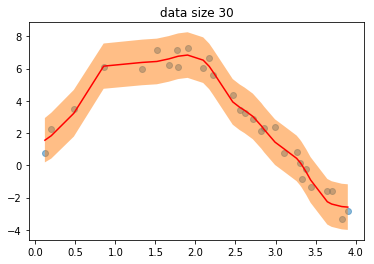

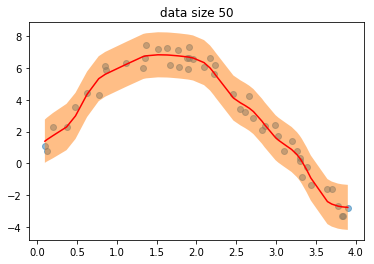

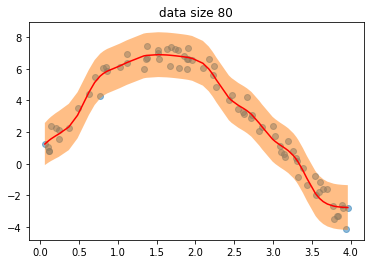

In [8]:
N_list = [10, 15, 30, 50, 80]
# N_list = [10]
for N in N_list:
    RM = RegressionModel()
    x = data['x'][:N]
    t = data['t'][:N]

    mN, SN = RM.posterior_distrib(x, t)
    
    plt.scatter(x, t, alpha = 0.5)
     
    x = np.array(sorted(x))
    mean, SD = RM.predict_distrib(x, mN, SN)

    plt.title('data size %d' % N)
    plt.plot(x, mean, 'r', label='mean')
    plt.fill_between(x.reshape(len(x)), mean-SD, mean+SD, alpha=0.5)
    plt.show()

In [9]:
# sklearn

# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import Pipeline
# import numpy as np
# model = Pipeline([('poly', PolynomialFeatures(degree=7)),
#                   ('linear', LinearRegression(fit_intercept=False))])

# X = data['x'][:50]
# y = data['t'][:50]
# plt.scatter(X, y, alpha = 0.5)
# model = model.fit(X, y)
# x = np.array(sorted(X))
# t = model.predict(x)

# plt.plot(x, t, 'r')